<a href="https://colab.research.google.com/github/onuralpArsln/MlAiTutorialProjects/blob/main/10-Pix2Pix/pix2pixprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Görsel işlemeler için

Bu çalışmada amaç elimizdeki düşük çözünürlüklü görüntüleri yüksek çözünürlükl hale getiren bir model oluşturmak istiyoruz.

In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.data import Dataset

import os
import math
import numpy as np

from IPython.display import display

Burada aslında 500 adet görsel olan basit bir dataset indiriyoruz. Manuel olarak onları düşük boyuta getirip sonrasında büyük boyutlu halleri ile eşleyerek yapay zeka eğitiminde kullancağız.

In [2]:
!wget -q "https://github.com/onuralpArsln/MlAiTutorialProjects/raw/refs/heads/main/10-Pix2Pix/archive.zip"


In [3]:
!unzip -q archive.zip

In [23]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

# Define paths
image_folder = "archive"  # Update with actual path
DOWNSCALE_FACTOR = 4  # Change this for different levels of downscaling

# Load images and create dataset
TARGET_SIZE = (256, 256)  # Adjust as needed

low_res_images, high_res_images = [], []

for img_name in os.listdir(image_folder):
    img_path = os.path.join(image_folder, img_name)

    # Load and resize high-res image
    high_res = img_to_array(load_img(img_path, target_size=TARGET_SIZE))

    # Create low-res image (downscale by factor of 4)
    low_res = cv2.resize(high_res, (TARGET_SIZE[0] // DOWNSCALE_FACTOR, TARGET_SIZE[1] // DOWNSCALE_FACTOR),
                          interpolation=cv2.INTER_CUBIC)

    # Store normalized versions for both original and flipped images
    low_res_images.append(low_res / 255.0)
    high_res_images.append(high_res / 255.0)

    # Add augmented (flipped) versions to the dataset
    flipped_low_res = np.fliplr(low_res)
    flipped_high_res = np.fliplr(high_res)

    # Append the flipped images
    low_res_images.append(flipped_low_res / 255.0)
    high_res_images.append(flipped_high_res / 255.0)

# Convert to NumPy arrays
low_res_images = np.array(low_res_images, dtype=np.float32)
high_res_images = np.array(high_res_images, dtype=np.float32)

# Create dataset
dataset = tf.data.Dataset.from_tensor_slices((low_res_images, high_res_images))
dataset = dataset.batch(32).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)


In [13]:
print(dataset.element_spec)

(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))


Low Res Shape: (64, 64, 64, 3)
High Res Shape: (64, 256, 256, 3)


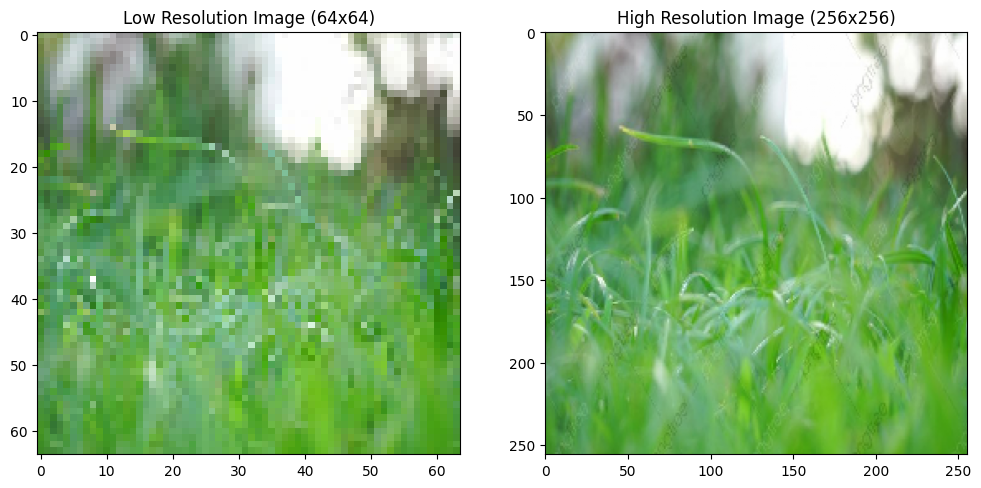

In [15]:
import matplotlib.pyplot as plt

# low_res: shape (batch_size, 64, 64, 3)
# high_res: shape (batch_size, 256, 256, 3)

print("Low Res Shape:", low_res.shape)
print("High Res Shape:", high_res.shape)

# Plot the first image in the batch
plt.figure(figsize=(12, 6))

# Low resolution image
plt.subplot(1, 2, 1)
plt.imshow(low_res[0].numpy())  # Display first image in batch
plt.title("Low Resolution Image (64x64)")

# High resolution image
plt.subplot(1, 2, 2)
plt.imshow(high_res[0].numpy())  # Display first image in batch
plt.title("High Resolution Image (256x256)")

plt.show()


In [16]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Add, Input, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model

def build_upscaler():
    # Input layer (Low-resolution 64x64x3)
    inputs = Input(shape=(64, 64, 3))  # Input size: (64, 64, 3) - 64x64 image with 3 channels (RGB)

    # Initial convolution block (feature extraction)
    x = Conv2D(64, (9, 9), padding="same")(inputs)  # Convolution with a kernel of size (9, 9), 64 filters
    x = LeakyReLU(alpha=0.2)(x)  # Activation using LeakyReLU to prevent vanishing gradients
    x = BatchNormalization()(x)  # Batch normalization to stabilize training

    # Size after this block: (64, 64, 64) - The image is still 64x64, but the number of channels has increased to 64

    # Feature extraction block with more filters
    x = Conv2D(128, (5, 5), padding="same")(x)  # Convolution with kernel size (5, 5), 128 filters
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization to help with faster convergence

    # Size after this block: (64, 64, 128) - The image is still 64x64, but the number of channels is now 128

    # Upscaling to 128x128 using transposed convolutions
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 64x64 → 128x128
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (128, 128, 128) - Image size has increased to 128x128 with 128 channels

    # Further upscaling to 256x256
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same")(x)  # Transposed conv: 128x128 → 256x256
    x = LeakyReLU(alpha=0.2)(x)  # LeakyReLU activation
    x = BatchNormalization()(x)  # Batch normalization

    # Size after this block: (256, 256, 64) - Image size has increased to 256x256 with 64 channels

    # Residual connection to preserve fine details
    residual = Conv2D(64, (5, 5), padding="same")(x)  # Convolution to extract finer details
    residual = LeakyReLU(alpha=0.2)(residual)  # LeakyReLU activation
    residual = BatchNormalization()(residual)  # Batch normalization

    # Residual connection: Adding the original feature map to the transformed feature map
    x = Add()([x, residual])  # The residual helps preserve finer details and avoid blurriness

    # Size after this block: (256, 256, 64) - The image size stays at 256x256, but the number of channels is 64

    # Final convolution layer to output 256x256 RGB image (3 channels)
    outputs = Conv2D(3, (5, 5), padding="same", activation="sigmoid")(x)  # Final conv: 256x256 → 256x256 with 3 channels

    # Size after this block: (256, 256, 3) - Final image size is 256x256 with 3 channels (RGB)

    # Create the model
    model = Model(inputs, outputs)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])  # Compile model with Adam optimizer and MSE loss

    return model

# Instantiate and summarize the model
model = build_upscaler()
model.summary()  # Summary shows the architecture details and layer output sizes


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 64)     │         15,616 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_10            │ (None, 64, 64, 64)     │              0 │ conv2d_8[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 64, 64, 64)     │            256 │ leaky_re_lu_10[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 128)    │        204,928 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_11            │ (None, 64, 64, 128)    │              0 │ conv2d_9[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 64, 64, 128)    │            512 │ leaky_re_lu_11[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 128, 128, 128)  │        262,272 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_12            │ (None, 128, 128, 128)  │              0 │ conv2d_transpose_4[0]… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 128, 128, 128)  │            512 │ leaky_re_lu_12[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 256, 256, 64)   │        131,136 │ batch_normalization_1… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_13            │ (None, 256, 256, 64)   │              0 │ conv2d_transpose_5[0]… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 256, 256, 64)   │            256 │ leaky_re_lu_13[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 256, 256, 64)   │        102,464 │ batch_normalization_1… │
├──────────────────────

 Total params: 723,011 (2.76 MB)

 Trainable params: 722,115 (2.75 MB)

 Non-trainable params: 896 (3.50 KB)

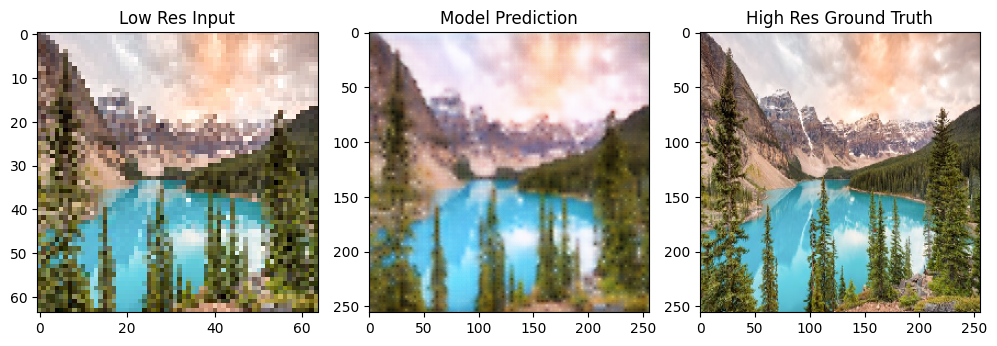

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0087 - mae: 0.0631
Epoch 27/150
12/32 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0086 - mae: 0.0625

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output

class DisplayPrediction(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data
        self.patience = 10
        self.best_loss = float('inf')
        self.epochs_without_improvement = 0

    def on_epoch_end(self, epoch, logs=None):

        # early stop
        current_loss = logs.get('loss')

        # Check if the loss has improved
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        # If loss hasn't improved for 'patience' epochs, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            self.model.stop_training = True

        # Get a sample of the validation data
        low_res, high_res = next(iter(self.val_data))

        # Ensure low_res and high_res have a batch dimension
        low_res = tf.expand_dims(low_res, axis=0) if len(low_res.shape) == 3 else low_res
        high_res = tf.expand_dims(high_res, axis=0) if len(high_res.shape) == 3 else high_res

        # Generate prediction from the model
        pred = self.model.predict(low_res)

        # Display images
        plt.figure(figsize=(10, 5))

        # Low-resolution input
        plt.subplot(1, 3, 1)
        plt.imshow(low_res[0])  # Show first image of batch
        plt.title("Low Res Input")

        # Model prediction
        plt.subplot(1, 3, 2)
        plt.imshow(pred[0])  # Show first predicted image
        plt.title("Model Prediction")

        # High-resolution ground truth
        plt.subplot(1, 3, 3)
        plt.imshow(high_res[0])  # Show first high-res image
        plt.title("High Res Ground Truth")

        plt.tight_layout()
        clear_output(wait=True)
        plt.show()

# Convert to tf.data.Dataset properly if it's not in batch form yet
val_data = tf.data.Dataset.from_tensor_slices((low_res_images[:10], high_res_images[:10]))  # Use 10 samples for validation
val_data = val_data.batch(1)  # Ensure the data is batched

# Add the callback to training
callback = DisplayPrediction(val_data)
#tf.dataset olduğundan batch size yukarda
# Train the model with the callback
model.fit(dataset, epochs=150, callbacks=[callback])


In [19]:
!wget -q  https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test1.jpg -O test1.jpg
!wget -q https://raw.githubusercontent.com/onuralpArsln/MlAiTutorialProjects/refs/heads/main/10-Pix2Pix/test2.jpg -O test2.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


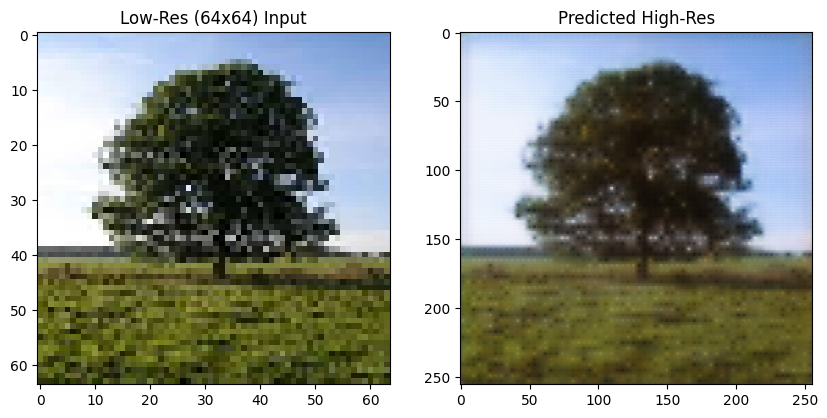

In [22]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path, target_size=(64, 64), downscale_factor=4):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.resize(img, (64, 64))


    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"
low_res, predicted = upscale_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 2, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.show()



Sace and use later

In [ ]:
# Save the model in H5 format
model.save("upscaler_model.h5")


In [ ]:
loaded_model = tf.keras.models.load_model("upscaler_model.h5")

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import tensorflow as tf

def upscale_new_image(model, image_path, target_size=(64, 64), downscale_factor=4):
    # Load the new image and resize it to 64x64
    img = img_to_array(load_img(image_path, target_size=target_size))

    # Create low-res version by downscaling (to simulate the low-res input for the model)
    low_res = cv2.resize(img, (64, 64))

    # Normalize the images
    low_res = low_res / 255.0
    img = img / 255.0

    # Expand dimensions for batch processing
    low_res = np.expand_dims(low_res, axis=0)

    # Make prediction using the model
    pred = model.predict(low_res)

    # Return both the resized low-res image and the prediction
    return low_res[0], pred[0]

# Example usage
image_path = "test1.jpg"

# Load model (if already saved and needs to be loaded)
# model = tf.keras.models.load_model("upscaler_model.h5")

# Predict with the model
low_res, predicted = upscale_new_image(model, image_path)

# Display the results
plt.figure(figsize=(10, 5))

# Display the low-resolution (64x64) input
plt.subplot(1, 2, 1)
plt.imshow(low_res)
plt.title("Low-Res (64x64) Input")

# Display the predicted high-resolution image
plt.subplot(1, 2, 2)
plt.imshow(predicted)
plt.title("Predicted High-Res")

plt.show()

# Save model for later use
model.save("upscaler_model.h5")  # Save the model